In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.version.VERSION)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-15 22:05:07.262509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 22:05:09.758502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [4]:
csv_path_test = 'input.csv'
csv_path_train = 'Tallinn-Harku-2004-2023.csv'

In [5]:
df = pd.read_csv(csv_path_train)
df = df.rename(columns={'Õhutemperatuur °C': 'temperature', 'Date Time': 'date', 'Tunni keskmine summaarne kiirgus W/m²' : 'radiation','Õhurõhk merepinna kõrgusel hPa' : 'pressure','Õhurõhk jaama kõrgusel hPa': 'pressure2','Tunni sademete summa mm' : 'precip','Suhteline õhuniiskus %' : 'humidity','Tunni miinimum õhutemperatuur °C' : 'tempmin','Tunni maksimum õhutemperatuur °C': 'tempmax','10 minuti keskmine tuule suund °' : 'winddir', '10 minuti keskmine tuule kiirus m/s' : 'windspeed', 'Tunni maksimum tuule kiirus m/s': 'windmax'})
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df['Aasta'].astype(str) + df['Kuu'].astype(str).str.zfill(2) + df['Päev'].astype(str).str.zfill(2) + df['Kell (UTC)'], format='%Y%m%d%H:%M')
df = df.drop(['Aasta', 'Kuu', 'Päev', 'Kell (UTC)'], axis=1)

df.dropna(inplace=True)
df.describe().transpose()

wv = df['windspeed']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['windmax']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['windspeed'].min()
wv = df.pop('windspeed')
max_wv = df.pop('windmax')

# Convert to radians.
wd_rad = df.pop('winddir')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [6]:
df.head()

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
2662,0.0,1014.8,1010.7,0.0,91.0,7.5,7.3,9.5,2.147235,0.824246,3.547606,1.361798,-5.000000e-01,0.866025,0.945045,-0.326940
2663,0.0,1014.6,1010.5,0.0,91.0,8.1,7.0,8.0,0.328512,2.074146,0.594451,3.753216,-2.588190e-01,0.965926,0.944811,-0.327617
2664,0.0,1014.3,1010.3,0.0,91.0,7.6,7.6,8.2,0.649838,1.785416,1.368081,3.758770,-2.478653e-13,1.000000,0.944575,-0.328294
2665,0.0,1014.2,1010.1,0.0,91.0,6.9,6.9,7.6,0.031410,0.899452,0.111678,3.198051,2.588190e-01,0.965926,0.944340,-0.328971
2666,0.0,1014.1,1010.0,0.0,91.0,6.5,6.4,6.9,0.177698,1.690687,0.292680,2.784661,5.000000e-01,0.866025,0.944104,-0.329648


In [7]:
df_test = pd.read_csv(csv_path_test)
df_test = df_test.rename(columns={'Õhutemperatuur °C': 'temperature', 'Date Time': 'date', 'Tunni keskmine summaarne kiirgus W/m²' : 'radiation','Õhurõhk merepinna kõrgusel hPa' : 'pressure','Õhurõhk jaama kõrgusel hPa': 'pressure2','Tunni sademete summa mm' : 'precip','Suhteline õhuniiskus %' : 'humidity','Tunni miinimum õhutemperatuur °C' : 'tempmin','Tunni maksimum õhutemperatuur °C': 'tempmax','10 minuti keskmine tuule suund °' : 'winddir', '10 minuti keskmine tuule kiirus m/s' : 'windspeed', 'Tunni maksimum tuule kiirus m/s': 'windmax'})
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df_test['Aasta'].astype(str) + df_test['Kuu'].astype(str).str.zfill(2) + df_test['Päev'].astype(str).str.zfill(2) + df_test['Kell (UTC)'], format='%Y%m%d%H:%M')
df_test = df_test.drop(['Aasta', 'Kuu', 'Päev', 'Kell (UTC)'], axis=1)

df_test.dropna(inplace=True)
df_test.describe().transpose()

wv_test = df_test['windspeed']
bad_wv_test = wv_test == -9999.0
wv_test[bad_wv_test] = 0.0

max_wv_test = df_test['windmax']
bad_max_wv_test = max_wv_test == -9999.0
max_wv_test[bad_max_wv_test] = 0.0

# The above inplace edits are reflected in the DataFrame.
df_test['windspeed'].min()
wv_test = df_test.pop('windspeed')
max_wv_test = df_test.pop('windmax')

# Convert to radians.
wd_rad_test = df_test.pop('winddir')*np.pi / 180

# Calculate the wind x and y components.
df_test['Wx'] = wv_test*np.cos(wd_rad_test)
df_test['Wy'] = wv_test*np.sin(wd_rad_test)

# Calculate the max wind x and y components.
df_test['max Wx'] = max_wv_test*np.cos(wd_rad_test)
df_test['max Wy'] = max_wv_test*np.sin(wd_rad_test)

timestamp_s_test = date_time.map(pd.Timestamp.timestamp)

day_test = 24*60*60
year_test = (365.2425)*day_test

df_test['Day sin'] = np.sin(timestamp_s_test * (2 * np.pi / day_test))
df_test['Day cos'] = np.cos(timestamp_s_test * (2 * np.pi / day_test))
df_test['Year sin'] = np.sin(timestamp_s_test * (2 * np.pi / year_test))
df_test['Year cos'] = np.cos(timestamp_s_test * (2 * np.pi / year_test))


/tmp/ipykernel_406/4001805798.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wv_test[bad_wv_test] = 0.0
/tmp/ipykernel_406/4001805798.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_wv_test[bad_max_wv_test] = 0.0


In [8]:
df_test.head()

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0,993.0,992.8,0.0,99,1.8,1.7,2.1,-3.300000,4.041334e-16,-6.800000,8.327598e-16,-7.977956e-12,1.000000,-0.036032,0.999351
1,0,993.1,992.9,0.0,99,1.9,1.8,2.1,-3.894655,2.041102e-01,-6.690818,3.506509e-01,2.588190e-01,0.965926,-0.035316,0.999376
2,0,993.1,992.9,0.0,99,1.5,1.5,2.0,-3.679731,-3.867553e-01,-7.757271,-8.153220e-01,5.000000e-01,0.866025,-0.034599,0.999401
3,0,993.1,992.9,0.0,99,2.1,1.4,2.1,-3.366911,4.731885e-01,-6.931876,9.742117e-01,7.071068e-01,0.707107,-0.033883,0.999426
4,0,993.1,992.9,0.1,100,1.9,1.9,2.2,-3.299497,5.759294e-02,-6.798964,1.186764e-01,8.660254e-01,0.500000,-0.033167,0.999450


(-9.563469101680758, 10.32306367136139, -12.074014356406266, 9.778114571891864)

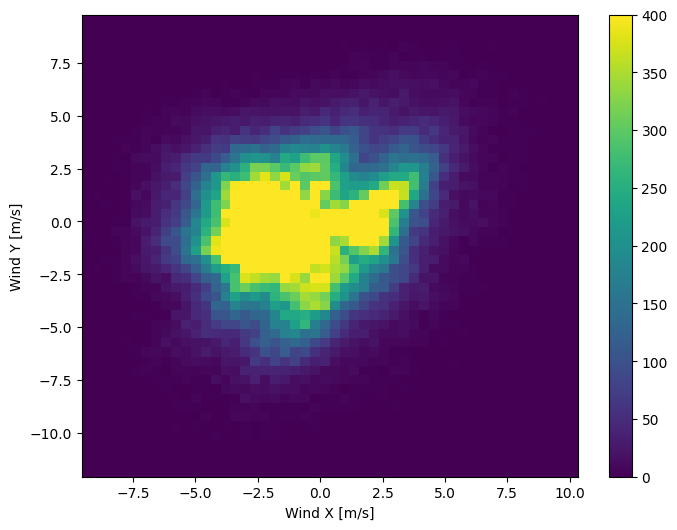

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Text(0.5, 1.0, 'Päeva signaal')

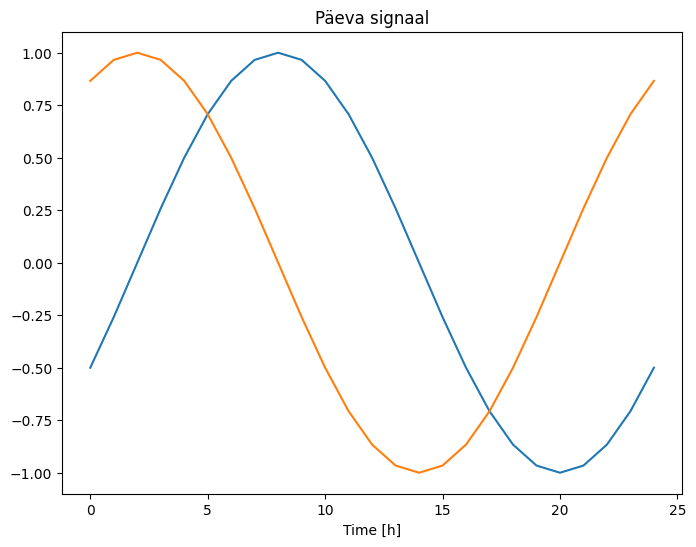

In [10]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Päeva signaal')

2024-03-15 22:05:16.586356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 22:05:16.587014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


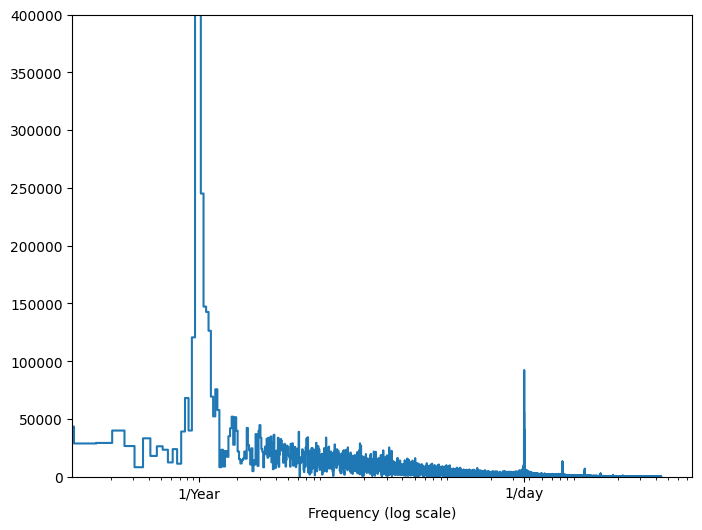

In [11]:
fft = tf.signal.rfft(df['temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['temperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n)]
test_df = df_test

num_features = df.shape[1]

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['temperature'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def plot(self, model=None, plot_col='temperature', max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])

In [22]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temperature'])

In [23]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    patience=patience,
    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[early_stopping])
  return history

In [24]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [25]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0490


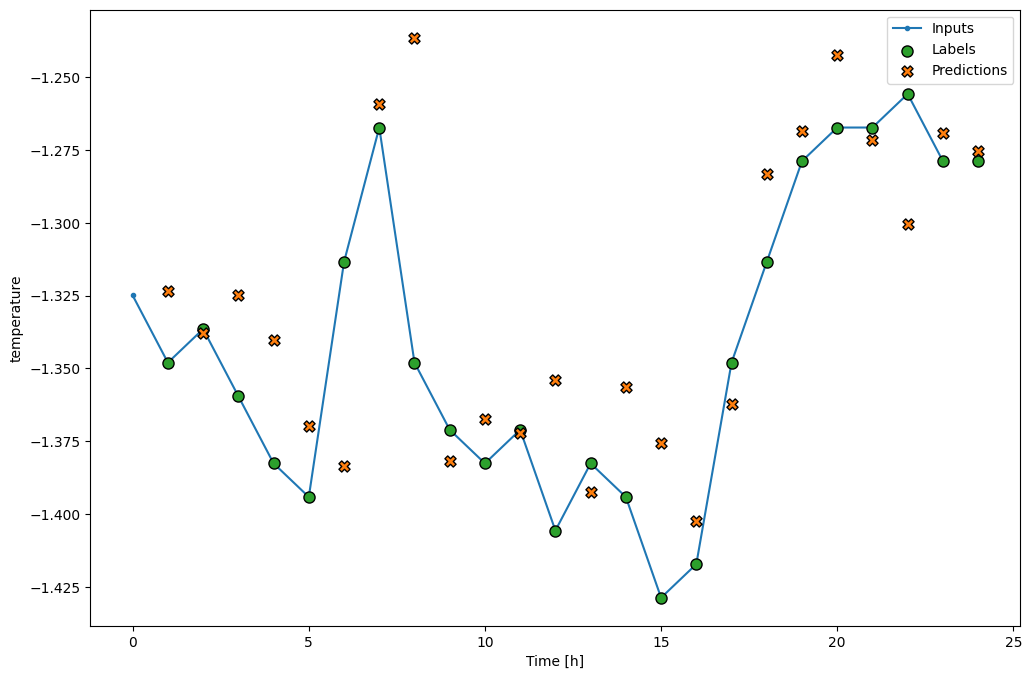

In [26]:
wide_window.plot(lstm_model)

In [27]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

In [28]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0692 - mean_absolute_error: 0.1011
CPU times: user 9min 8s, sys: 1min 43s, total: 10min 51s
Wall time: 3min 43s


In [29]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [30]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))
a = df_test.temperature[47]
history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0723 - mean_absolute_error: 0.1009
CPU times: user 6min 24s, sys: 1min 14s, total: 7min 38s
Wall time: 2min 41s


In [31]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS)

In [33]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}
#multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

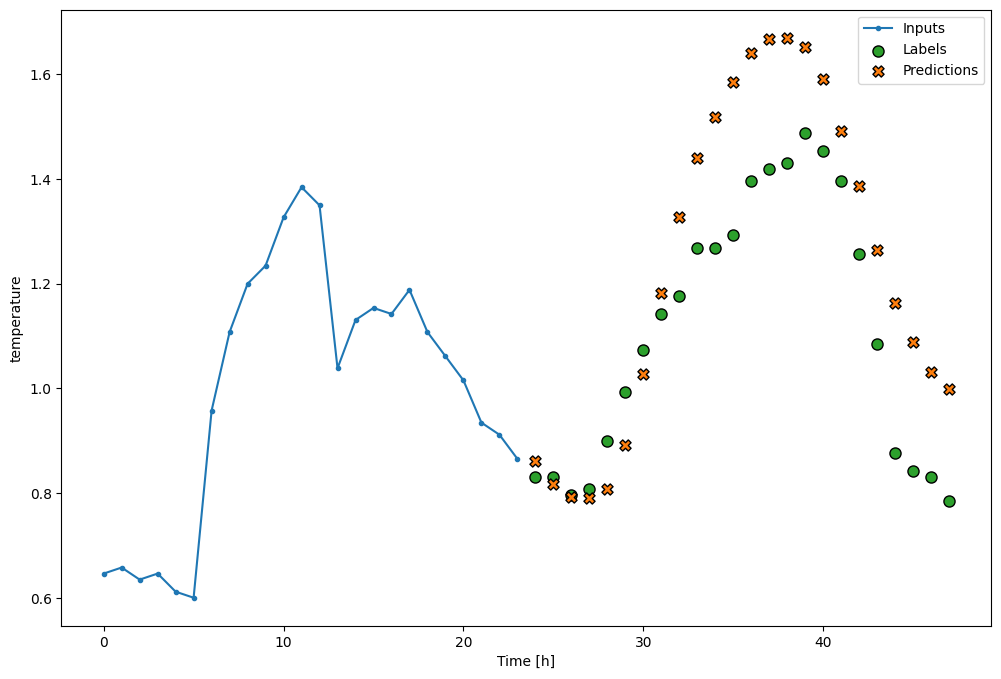

In [ ]:
multi_window.plot(multi_conv_model)

In [38]:
mean = train_mean
std = train_std

#test_df = (df - mean) / std
test_df = df_test
a = round(std.temperature, 1)

reshaped_data = test_df.values.reshape(-1, 24, 16)

# Now you can use this reshaped data for prediction
multi_conv_model.summary()
predictions = multi_conv_model.predict(reshaped_data)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 256)         │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 384)         │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 24, 16)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,698 (1.27 MB)

 Trainable params: 111,232 (434.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,466 (869.01 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [39]:
elem = ['Õhutemperatuur °C', 'Date Time', 'Tunni keskmine summaarne kiirgus W/m²','Õhurõhk merepinna kõrgusel hPa','Õhurõhk jaama kõrgusel hPa','Tunni sademete summa mm' ,'Suhteline õhuniiskus %' ,'Tunni miinimum õhutemperatuur °C' ,'Tunni maksimum õhutemperatuur °C','10 minuti keskmine tuule suund °', '10 minuti keskmine tuule kiirus m/s', 'Tunni maksimum tuule kiirus m/s', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
andmed = {}
for f in range(16):
    andmed[elem[f]] = []

for i in predictions[1]:
    for f in range(16):
        andmed[elem[f]].append(i[f])

print(andmed)

{'Õhutemperatuur °C': [4.6538095, 27.063622, 38.885574, 37.757866, 80.38125, 103.76405, 94.6898, 85.70164, 91.25098, 115.2271, 162.26677, 136.66527, 158.16655, 120.23584, 141.73094, 181.56577, 235.02632, 280.17596, 291.30902, 294.8928, 230.35313, 162.43268, 120.37497, 67.08814], 'Date Time': [1060.4108, 1066.3517, 1082.002, 1098.2106, 1111.2882, 1120.7671, 1136.2126, 1153.6676, 1166.2211, 1174.5669, 1176.1107, 1173.5709, 1170.824, 1163.7385, 1159.2318, 1156.3176, 1155.3849, 1147.3795, 1138.3822, 1131.7831, 1122.9912, 1114.9271, 1103.382, 1090.2516], 'Tunni keskmine summaarne kiirgus W/m²': [1063.848, 1068.5057, 1083.3345, 1101.6534, 1115.0995, 1124.3652, 1139.3561, 1156.7015, 1168.5259, 1177.1654, 1178.4666, 1176.5613, 1173.8074, 1167.0688, 1163.006, 1159.756, 1159.7827, 1152.1123, 1143.3905, 1136.0533, 1127.0365, 1117.8907, 1106.7501, 1093.371], 'Õhurõhk merepinna kõrgusel hPa': [153.31844, -125.69904, -58.929752, -45.21709, -70.90337, -262.6863, -197.67067, -149.90044, -193.16985, -2

In [42]:
temp = std.temperature*andmed['Õhutemperatuur °C'][23]+mean.temperature
b = a + temp/1000

In [43]:
print(a, "°C kuni ", round(b, 1), "°C")

8.7 °C kuni  9.3 °C
